# <font color=blue>Team
- W207 Spring 2020, Wednesday 6:30pm section, Holloway
- Kaggle: House Prices: Advanced Regression Techniques
- Team Name on Kaggle: w207s20
- Team: Imran Manji, Madhukar Reddy, Travis Metz

In [0]:
%matplotlib inline 

import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import joblib

# SK-learn libraries for machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import BayesianRidge
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from mlxtend.regressor import StackingCVRegressor
# from lightgbm import LGBMRegressor
from lightgbm import *
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import xgboost

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

# SK-learn libraries for evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")
pass

In [4]:
# please provide your custom path to run

# #Google Colab Code
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# df_train = pd.read_csv("/content/drive/My Drive/207_Ames House Price Prediction \
# Project/house-prices-advanced-regression-techniques/train.csv")
# df_test = pd.read_csv("/content/drive/My Drive/207_Ames House Price Prediction \
# Project/house-prices-advanced-regression-techniques/test.csv")

# Local Code
df_train = pd.read_csv("house-prices-advanced-regression-techniques/train.csv")
df_test = pd.read_csv("house-prices-advanced-regression-techniques/test.csv")

print("Train size: {0}, Test size: {1}".format(df_train.shape,df_test.shape))

Mounted at /content/drive
Train size: (1460, 81), Test size: (1459, 80)


In [5]:
# please provide your custom path to run the best_models_file.pkl file
# load precomputed models to be able to run various individual models

# #Google Colab Code
# drive.mount('/content/gdrive')
# best_models_save_path = F"/content/gdrive/My Drive/207_Ames House Price \
# Prediction Project/house-prices-advanced-regression-techniques/models/\
# best_models_file.pkl"
# best_models = joblib.load(best_models_save_path)


#Local Code
best_models = joblib.load('best_models_file.pkl')

Mounted at /content/gdrive


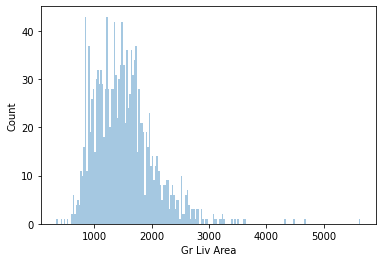

In [6]:
df_train_new = df_train.copy() # create copy
df_test_new = df_test.copy()

sns.distplot(df_train_new.GrLivArea, kde=False, bins=200)
plt.xlabel("Gr Liv Area")
plt.ylabel("Count")

df_train_new = df_train_new[df_train.GrLivArea < 4000] # remove 4 outliers >4000
n_rows = len(df_train_new)

df_X = df_train_new.iloc[:,:80] # columns 0-80 are X data
df_Y = df_train_new.iloc[:,80] # label data
df_Y = np.log(df_Y) # covert SalePrice to logarithmic
df_X_combined = pd.concat([df_X, df_test_new]) # combines df_X plus df_test
train_dev_labels = df_Y[:n_rows]

### Feature engineering

In [0]:
num_features = df_X.describe().columns
df_features = pd.DataFrame(num_features)
df_SF_features = df_features.loc[[3, 9, 10, 11, 12, 13, 14, 15, 16]]
df_SF_features = list(df_SF_features.values.flatten())

# transform the combined dataset
df_X_combined["Total_Area"] = df_X_combined[df_SF_features].sum(axis=1)
df_X_combined["GrArea_Ratio"] = df_X_combined.GrLivArea/df_X_combined.Total_Area 
pass

# <font color=blue> ETL
## <font color=blue> Pipeline
1. Data imputation
- Missing values in numerical features were imputed with the median of the given feature distribution.
- Missing values in categorical features were imputed with most frequently occuring value in the given feature distribution.

2. One-hot encoding
- Only categorical features were one-hot-encoded

3. Scaling
- Numerical features were standard scaled, while categorical features were untouched.



In [0]:
# divide data vertically into numerical and categorical data
categories_logical = np.array(df_X_combined.dtypes == "object").T 
numericals_logical = np.array(df_X_combined.dtypes != "object").T

# hack to get feature names from df_X_dummies
numericals_list = list(df_X_combined.columns[numericals_logical])
categories_list = list(df_X_combined.columns[categories_logical])

# reorder the dataframe to have numerical columns first, then categoricals
df_X_combined_ordered = pd.concat([df_X_combined[numericals_list], \
                                   df_X_combined[categories_list]], axis=1)

# use the following to get feature names for OHE dataframe 
# (first columns are numerical, last are OHE categorical)
df_X_combined_dummies_ordered = pd.get_dummies(df_X_combined_ordered, \
                                               drop_first=True) 

In [0]:
# impute categorical data

from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
  """
  By inheriting TransformerMixin, you get fit_transform method for free 
  if you implement fit and transform methods
  """ 

  def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.
        Columns of other types are imputed with median of column.
        """
  def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X], 
            index=X.columns)
        return self

  def transform(self, X, y=None):
        return X.fillna(self.fill)

In [0]:
# Pipeline for numerical columns
# 1. fill NA's with median values
# 2. scale them
num_pipeline_impute_ss = Pipeline([        # should be list of tuples
                          ("num_imputer", SimpleImputer(strategy="median")),
                          ("std_scaler", StandardScaler())
                          ])                      

# Pipleline for categorical columns
# 1. fill NA's with most frequent values
# 2. one hot code

cat_pipeline_impute_ohe = Pipeline([("cat_imputer", DataFrameImputer()),
                         ("one_hot_encoder", OneHotEncoder(drop="first", \
                                                           sparse=False))
                         ])

## <font color=blue>ColumnTransformer

In [0]:
# here trying to do numerical and categorical transformation in isolation
# this because ColumnTransformer removes column name information :-(
from sklearn.compose import ColumnTransformer

# only the cat columns will be one-hot encoded
partial_transformer_impute_ohe = ColumnTransformer([
                                   ("categorical_ohe", cat_pipeline_impute_ohe,\
                                    categories_list)
])

# only the numerical columns withh get standard scaling
partial_transformer_impute_ss = ColumnTransformer([
                                   ("numerical_ss_impute", num_pipeline_impute_ss,\
                                    numericals_list)
])

In [0]:
# Transform categorical and numerical columns separately

# 1. One hot code full combined dataset's category columns using cat_ohe
partial_transformer_impute_ohe.fit(df_X_combined_ordered)
cat_data_OHE = partial_transformer_impute_ohe.transform(df_X_combined_ordered)
cat_data_OHE.shape #(2915, 208) spits out only only categorical columns
# convert into dataframe
df_cat_data_OHE = pd.DataFrame(cat_data_OHE, \
                               columns=df_X_combined_dummies_ordered.columns[len(numericals_list):])

# 2. impute and scale numerical columns
# fit on train+dev+test data
partial_transformer_impute_ss.fit(df_X_combined_ordered[numericals_list][:1100]) # first 39 numerical columns are pulled from df_X_combined_ordered
# ...then transform train+dev+test data
full_data_ohe_ss_imputed = partial_transformer_impute_ss.transform(df_X_combined_ordered[numericals_list]) # this is just the numerical columns

# slice out the train, dev and test AND train+dev
train_data_ohe_ss_imputed = full_data_ohe_ss_imputed[:1100] # train (1100, 39)
dev_data_ohe_ss_imputed = full_data_ohe_ss_imputed[1100:n_rows] # dev (356, 39)
test_data_ohe_ss_imputed = full_data_ohe_ss_imputed[n_rows:] # test (xxx, 39)
train_dev_data_ohe_ss_imputed = full_data_ohe_ss_imputed[:n_rows] # train+dev

# join vertically together numerical and categorical features of transformed train, dev, test
train_combined_rebuilt = np.hstack((train_data_ohe_ss_imputed, cat_data_OHE[:1100, :])) # train
dev_combined_rebuilt = np.hstack((dev_data_ohe_ss_imputed, cat_data_OHE[1100:n_rows, :])) #dev
test_combined_rebuilt = np.hstack((test_data_ohe_ss_imputed, cat_data_OHE[n_rows:, :])) # test
train_dev_combined_rebuilt = np.hstack((train_dev_data_ohe_ss_imputed, cat_data_OHE[:n_rows, :])) # train+dev

# <font color=blue>Metric of Evaluation

We used Root Mean Square of Logarithmic Error (that is, RMSE after transforming Y to log(Y)) as our metric of evaluation to match the same for the Kaggle content.
- Further, throughout, cross-validation was implemented to ensure best estimation of RMSE
- Standard scaling was done on train+dev+test data







In [0]:
from sklearn.metrics import make_scorer
def my_scoring_func(y_predict, y_true):
  """
  Returns RMSE
  """
  
  error = y_predict - y_true
  return -np.sqrt(np.mean(error**2)) # negative because the some sklearn estimators expect 'greater_is_better=True' in make_scorer

my_scorer = make_scorer(my_scoring_func, greater_is_better=True)

# <font color=blue>Train, Dev and Test set
- During the first stage of our analysis (not reported in detail in this notebook), we created a train set consisting of 1100 examples, and a dev set consisting of 460 examples. Kaggle's test set (with 1459 examples) worked as our true test set.
- After our project matured, we used cross-validation extensively, and therefore there was no need for an explicit dev set. The train and dev sets were combined as is presented in this notebook.

# <font color=blue> **Outlier Identification**

We used unsupervised techniques (k-means Clustering and PCA) for outlier detection. Criterion for outlier removal is discussed at relavent locations in the following sections.

# <font color=blue> Clustering
- Principal compoents of the data were first identified using PCA()
- Then we used clustering to identify outlier clusters in the principal component plots. For instance, in the second plot below, cluster 19 was determined to be outliers. (We ran the full analysis both with and without these datapoints, and found that removal indeed helped with prediction not only on cross-validated training set but also the test set on Kaggle).


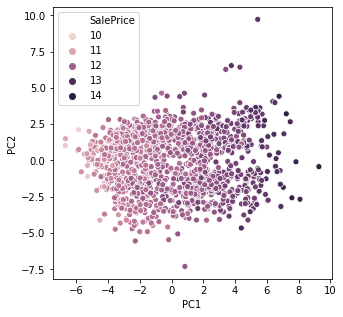

In [14]:
def P2(n_components, data): # from Project 3!
  """
  Takes target dimensionality reduction (k) and the data to reduce
  Returns the reduced data
  """
  
  pca = PCA(n_components)
  pca.fit(data)
  reduced_data = pca.transform(data)
  return reduced_data 

# Dimension reduction
reduced_train_data = P2(n_components=2, data=train_dev_combined_rebuilt)
pc1, pc2 = reduced_train_data[:, 0], reduced_train_data[:, 1]

import seaborn as sns
colors = ["g", "r"]
fig, ax = plt.subplots(figsize=(5, 5))
sns.set_palette(sns.color_palette(colors))
sns.scatterplot(x=pc1, y=pc2, hue=train_dev_labels)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
pass

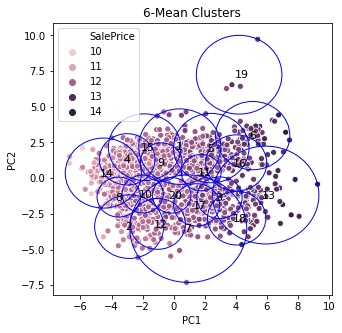

In [15]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

def P3(train_data):
    pca=PCA(n_components=2)
    pca.fit(train_data)
    reduced_train_data = pca.transform(train_data)

    for n_clusters in [20]:
        kmeans=KMeans(n_clusters=n_clusters,random_state=0)
        kmeans.fit(reduced_train_data)

        colors = ["g", "r"]
        fig, ax = plt.subplots(figsize=(5, 5))
        X, Y = reduced_train_data[:, 0], reduced_train_data[:, 1]
        sns.scatterplot(x=X, y=Y, hue=train_dev_labels)
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")

        for i in range(n_clusters):
            radii = cdist(reduced_train_data[kmeans.labels_ == i], [kmeans.cluster_centers_[i]], metric="euclidean").max()
            circle = plt.Circle(kmeans.cluster_centers_[i], radii, color="#00000000", ec="blue")
            ax.add_patch(circle)
            plt.text(kmeans.cluster_centers_[i][0]-0.25,kmeans.cluster_centers_[i][1]-0.25,str(i+1),color="black",size=11)

        ax.set_title("6-Mean Clusters")
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        #plt.show()
        
P3(train_dev_combined_rebuilt)

In [0]:
# outlier removal in cluster 19
kmeans_outliers_logical = (pc2 < 5.3)*1

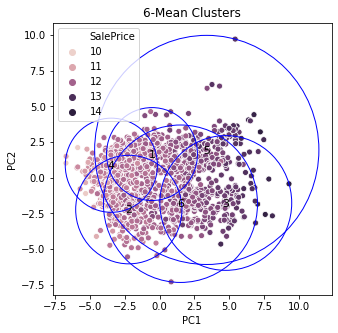

In [17]:
# re-run clustering on the filtered data
# keep track of the train_labels!
# Summary: no new outlliers

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

def P3(train_data):
    pca=PCA(n_components=2)
    pca.fit(train_data)
    reduced_train_data = pca.transform(train_data)

    for n_clusters in [6]:
        kmeans=KMeans(n_clusters=n_clusters,random_state=0)
        kmeans.fit(reduced_train_data)

        colors = ["g", "r"]
        fig, ax = plt.subplots(figsize=(5, 5))
        X, Y = reduced_train_data[:, 0], reduced_train_data[:, 1]
        sns.scatterplot(x=X, y=Y, hue=train_dev_labels) #[kmeans_outliers_logical])
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")

        for i in range(n_clusters):
            radii = cdist(reduced_train_data[kmeans.labels_ == i], [kmeans.cluster_centers_[i]], metric="euclidean").max()
            circle = plt.Circle(kmeans.cluster_centers_[i], radii, color="#00000000", ec="blue")
            ax.add_patch(circle)
            plt.text(kmeans.cluster_centers_[i][0]-0.25,kmeans.cluster_centers_[i][1]-0.25,str(i+1),color="black",size=11)

        ax.set_title("6-Mean Clusters")
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        #plt.show()
        
# pass in the filtered data here        
# P3(train_dev_combined_rebuilt_kmeans)
P3(train_dev_combined_rebuilt)

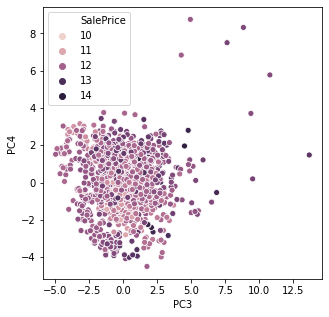

In [18]:
def P2(n_components, data):
  """
  Takes target dimensionality reduction (k) and the data to reduce
  Returns the reduced data
  """
  
  pca = PCA(n_components)
  pca.fit(data)
  reduced_data = pca.transform(data)
  return reduced_data 

# note the filtered version of data passed in here
reduced_train_data = P2(n_components=10, data=train_dev_combined_rebuilt)
pc3, pc4 = reduced_train_data[:, 2], reduced_train_data[:, 3]

import seaborn as sns
colors = ["g", "r"]
fig, ax = plt.subplots(figsize=(5, 5))
sns.set_palette(sns.color_palette(colors))

# note the filtered version of labels passed in here
sns.scatterplot(x=pc3, y=pc4, hue=train_dev_labels)

ax.set_xlabel("PC3")
ax.set_ylabel("PC4")
pass

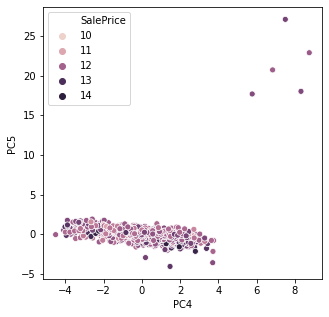

In [19]:
# So, lets look again in pc1 vs pc2 so on

def P2(n_components, data):
  """
  Takes target dimensionality reduction (k) and the data to reduce
  Returns the reduced data
  """
  
  pca = PCA(n_components)
  pca.fit(data)
  reduced_data = pca.transform(data)
  return reduced_data 

# note the filtered version of data passed in here
reduced_train_data = P2(n_components=10, data=train_dev_combined_rebuilt)
pc4, pc5 = reduced_train_data[:, 3], reduced_train_data[:, 4]

import seaborn as sns
colors = ["g", "r"]
fig, ax = plt.subplots(figsize=(5, 5))
sns.set_palette(sns.color_palette(colors))

# note the filtered version of labels passed in here
sns.scatterplot(x=pc4, y=pc5, hue=train_dev_labels)

ax.set_xlabel("PC4")
ax.set_ylabel("PC5")
pass

## <font color=blue> Above, 5 data points greater than pc4=5 are considered outliers

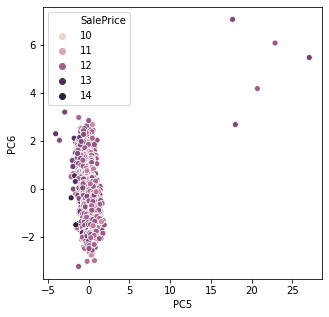

In [20]:
# So, lets look again in pc1 vs pc2 so on

def P2(n_components, data):
  """
  Takes target dimensionality reduction (k) and the data to reduce
  Returns the reduced data
  """
  
  pca = PCA(n_components)
  pca.fit(data)
  reduced_data = pca.transform(data)
  return reduced_data 

# note the filtered version of data passed in here
reduced_train_data = P2(n_components=10, data=train_dev_combined_rebuilt)
pc5, pc6 = reduced_train_data[:, 4], reduced_train_data[:, 5]

import seaborn as sns
colors = ["g", "r"]
fig, ax = plt.subplots(figsize=(5, 5))
sns.set_palette(sns.color_palette(colors))

# note the filtered version of labels passed in here
sns.scatterplot(x=pc5, y=pc6, hue=train_dev_labels)

ax.set_xlabel("PC5")
ax.set_ylabel("PC6")
pass

## <font color=blue> Above, 5 data points greater than pc5=5 are considered outliers

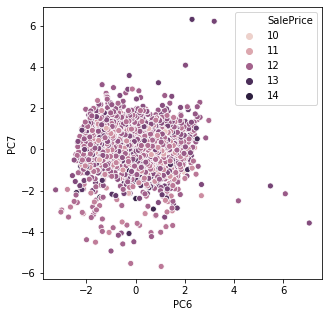

In [21]:
# So, lets look again in pc1 vs pc2 so on

def P2(n_components, data):
  """
  Takes target dimensionality reduction (k) and the data to reduce
  Returns the reduced data
  """
  
  pca = PCA(n_components)
  pca.fit(data)
  reduced_data = pca.transform(data)
  return reduced_data 

# note the filtered version of data passed in here
reduced_train_data = P2(n_components=10, data=train_dev_combined_rebuilt)
pc6, pc7 = reduced_train_data[:, 5], reduced_train_data[:, 6]

import seaborn as sns
colors = ["g", "r"]
fig, ax = plt.subplots(figsize=(5, 5))
sns.set_palette(sns.color_palette(colors))

# note the filtered version of labels passed in here
sns.scatterplot(x=pc6, y=pc7, hue=train_dev_labels)

ax.set_xlabel("PC6")
ax.set_ylabel("PC7")
pass

## <font color=blue> Outliers are removed here:

In [22]:
outliers_kmeans = kmeans_outliers_logical
outliers_pca_round1 = ((pc4 < 5)*1)
outliers_pca_round2 = ((pc5 < 5)*1)
kmeans_outliers_logical = outliers_kmeans * outliers_pca_round1 * outliers_pca_round2
kmeans_outliers_logical = kmeans_outliers_logical==1
train_dev_combined_rebuilt_kmeans = train_dev_combined_rebuilt[kmeans_outliers_logical]
print(train_dev_combined_rebuilt_kmeans.shape)

(1447, 247)


In [0]:
# rename the filtered data to original object names
train_dev_combined_rebuilt = train_dev_combined_rebuilt_kmeans
train_dev_labels = train_dev_labels[kmeans_outliers_logical]

# <font color=blue>kNN Regression with CV

RMSE: 0.20558895074118136
R-squared: 0.86
Slope: 0.812
Slope (in degs): 39.09



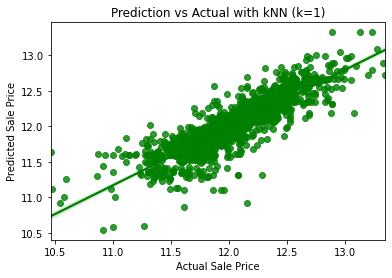

In [24]:
knn_reg = KNeighborsClassifier(n_neighbors=1)
y_predict = cross_val_predict(knn_reg, train_dev_combined_rebuilt, np.floor(np.exp(train_dev_labels)))
print("RMSE:", -my_scoring_func(np.log(y_predict), train_dev_labels))

slope, intercept, r_value, p_value, std_err = stats.linregress(train_dev_labels, np.log(y_predict))
ax = sns.regplot(train_dev_labels, np.log(y_predict))
ax.set_title("Prediction vs Actual with kNN (k=1)")
ax.set_xlabel("Actual Sale Price")
ax.set_ylabel("Predicted Sale Price")
print("R-squared:", round(r_value, 3))
print("Slope:", round(slope, 3))
print("Slope (in degs):", round(np.arctan(slope)*180/np.pi, 2))
print()

# <font color=blue> Linear Regression
- Does not work well

RMSE: 17793680.17541532
R-squared: -0.086
Slope: -3872537.564
Slope (in degs): -90.0



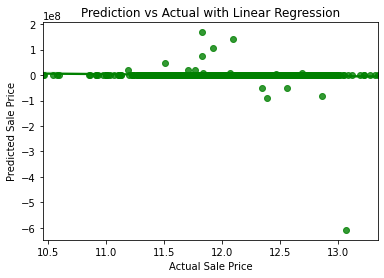

In [25]:
lr_reg = LinearRegression()
y_predict = cross_val_predict(lr_reg, train_dev_combined_rebuilt, train_dev_labels)
print("RMSE:", -my_scoring_func(y_predict, train_dev_labels))

slope, intercept, r_value, p_value, std_err = stats.linregress(train_dev_labels, y_predict)
ax = sns.regplot(train_dev_labels, y_predict)
ax.set_title("Prediction vs Actual with Linear Regression")
ax.set_xlabel("Actual Sale Price")
ax.set_ylabel("Predicted Sale Price")
print("R-squared:", round(r_value, 3))
print("Slope:", round(slope, 3))
print("Slope (in degs):", round(np.arctan(slope)*180/np.pi, 2))
print()

# <font color=blue>Lasso Regression with CV
- RMSE 0.11214






RMSE: 0.11346643564913078
R-squared: 0.958
Slope: 0.923
Slope (in degs): 42.7



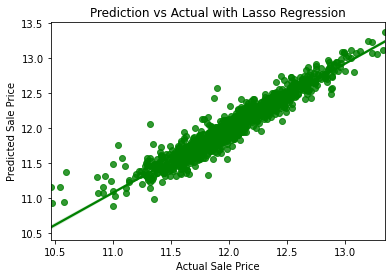

In [26]:
lasso_reg = best_models["lasso"]
y_predict = cross_val_predict(lasso_reg, train_dev_combined_rebuilt, train_dev_labels)
print("RMSE:", -my_scoring_func(y_predict, train_dev_labels))

slope, intercept, r_value, p_value, std_err = stats.linregress(train_dev_labels, y_predict)
ax = sns.regplot(train_dev_labels, y_predict)
ax.set_title("Prediction vs Actual with Lasso Regression")
ax.set_xlabel("Actual Sale Price")
ax.set_ylabel("Predicted Sale Price")
print("R-squared:", round(r_value, 3))
print("Slope:", round(slope, 3))
print("Slope (in degs):", round(np.arctan(slope)*180/np.pi, 2))
print()

# <font color=blue>RidgeCV
- no difference between scaled vs unscaled data
- RMSE 0.11002



RMSE: 0.11425328480109288
R-squared: 0.957
Slope: 0.92
Slope (in degs): 42.61



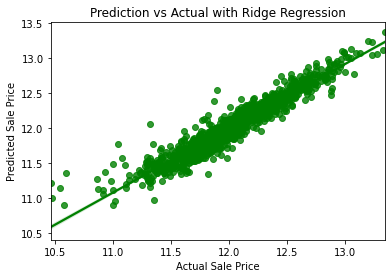

In [27]:
ridge_reg = best_models["ridge"]
y_predict = cross_val_predict(ridge_reg, train_dev_combined_rebuilt, train_dev_labels)
print("RMSE:", -my_scoring_func(y_predict, train_dev_labels))

slope, intercept, r_value, p_value, std_err = stats.linregress(train_dev_labels, y_predict)
ax = sns.regplot(train_dev_labels, y_predict)
ax.set_title("Prediction vs Actual with Ridge Regression")
ax.set_xlabel("Actual Sale Price")
ax.set_ylabel("Predicted Sale Price")
print("R-squared:", round(r_value, 3))
print("Slope:", round(slope, 3))
print("Slope (in degs):", round(np.arctan(slope)*180/np.pi, 2))
print()

# <font color=blue>ElasticNetCV
- no difference between scaled vs unscaled data
- RMSE 0.10813


RMSE: 0.11354426808872588
R-squared: 0.958
Slope: 0.924
Slope (in degs): 42.73



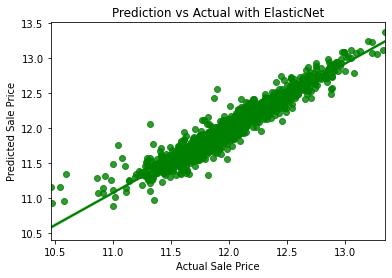

In [28]:
elasticnet_reg = best_models["elasticnet"]
y_predict = cross_val_predict(elasticnet_reg, train_dev_combined_rebuilt, train_dev_labels)
print("RMSE:", -my_scoring_func(y_predict, train_dev_labels))

slope, intercept, r_value, p_value, std_err = stats.linregress(train_dev_labels, y_predict)
ax = sns.regplot(train_dev_labels, y_predict)
ax.set_title("Prediction vs Actual with ElasticNet")
ax.set_xlabel("Actual Sale Price")
ax.set_ylabel("Predicted Sale Price")
print("R-squared:", round(r_value, 3))
print("Slope:", round(slope, 3))
print("Slope (in degs):", round(np.arctan(slope)*180/np.pi, 2))
print()

# <font color=blue> Linear SVM Regression


RMSE: 0.19964446291346583
R-squared: 0.878
Slope: 0.91
Slope (in degs): 42.3



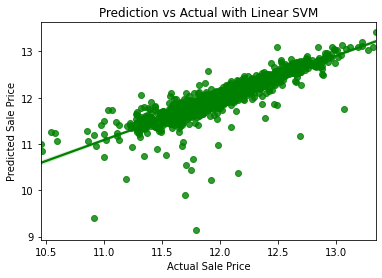

In [29]:
svr_reg = LinearSVR()
params_svr = {"C" : list(np.linspace(1.2,1.7, 10)),\
              "epsilon": [0.9e-6]} 
grid_search_svr = GridSearchCV(svr_reg, param_grid=params_svr, refit=True,\
                               scoring=my_scorer)
grid_search_svr.fit(train_dev_combined_rebuilt, train_dev_labels)
svr_best_model = grid_search_svr.best_estimator_

y_predict = cross_val_predict(svr_best_model, train_dev_combined_rebuilt, train_dev_labels)
print("RMSE:", -my_scoring_func(y_predict, train_dev_labels))

slope, intercept, r_value, p_value, std_err = stats.linregress(train_dev_labels, y_predict)
ax = sns.regplot(train_dev_labels, y_predict)
ax.set_title("Prediction vs Actual with Linear SVM")
ax.set_xlabel("Actual Sale Price")
ax.set_ylabel("Predicted Sale Price")
print("R-squared:", round(r_value, 3))
print("Slope:", round(slope, 3))
print("Slope (in degs):", round(np.arctan(slope)*180/np.pi, 2))
print()

# <font color=blue>SVM
- RobustScaler() froze the program
- SVR gave RMSE of 0.10637

Since we have a relatively small dataset in hand, Support Vector Machines are ideal for the purpose. We noticed that rmse obtained using SVMs was very sensitive to scaling, hence we used standard scaling. On the other hand, RobustScaler() which removes the median and scales the data to the quartile range froze the program.

Hyperparameters: We ran RandomizedSearchCV on kernels (rbf, linear), C, gamma and epsilon. Linear kernel worked the best. Lower value of C leads to larger margin and thus high margin violations. Larger values of C leads to few margin violations, but may not generalize well. The following worked best.
> SVR(C=0.012555555555555556, cache_size=200, coef0=0.0, degree=3, epsilon=0.03,
    gamma=0.0001, kernel='linear', max_iter=-1, shrinking=True, tol=0.001,
    verbose=False)

We noticed that LinearSVC() that is based on the liblinear library gave slightly worse RMSE than SVR() class (not attributable to hyperparameter selection). The SVR() class is based on is based onthe libsvm library which implements an algorithm that supports kernel trick, so may be that was the difference.



RMSE: 0.11397342090348252
R-squared: 0.958
Slope: 0.904
Slope (in degs): 42.11



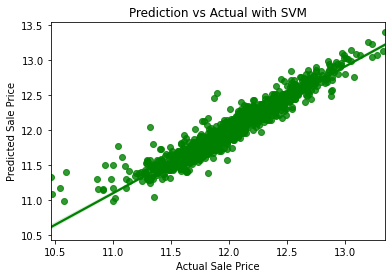

In [30]:
# SVM Regression
svm_reg = best_models["svr"] #SVR(kernel="linear", gamma=1e-4, epsilon=0.03, C=0.0125)
y_predict = cross_val_predict(svm_reg, train_dev_combined_rebuilt, train_dev_labels)
print("RMSE:", -my_scoring_func(y_predict, train_dev_labels))

slope, intercept, r_value, p_value, std_err = stats.linregress(train_dev_labels, y_predict)
ax = sns.regplot(train_dev_labels, y_predict)
ax.set_title("Prediction vs Actual with SVM")
ax.set_xlabel("Actual Sale Price")
ax.set_ylabel("Predicted Sale Price")
print("R-squared:", round(r_value, 3))
print("Slope:", round(slope, 3))
print("Slope (in degs):", round(np.arctan(slope)*180/np.pi, 2))
print()

# <font color=blue>Decision Trees

Decision Trees like orthogonal decision boundaries. Meaning, a perfectly linearly separable dataset rotated by an angle, say 30 degrees, will result in complicated stepped decision boundaries. To mitigate this, we used PCA transformation to re-orient the dataset to principal compoents, but it did not help. This could be due to overfitting by DTs. Hence, we looked into RFs, Gradient Boosted Decision Trees and Extreme Gradient Boosted DTs (XGBoost). 



RMSE: 0.20449998042467138
R-squared: 0.865
Slope: 0.855
Slope (in degs): 40.52



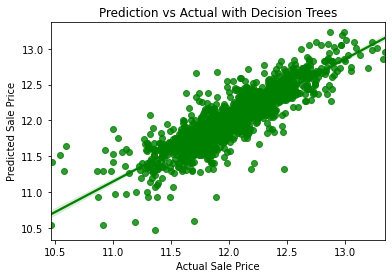

In [31]:
# DT Regression
dt_reg = DecisionTreeRegressor()
y_predict = cross_val_predict(dt_reg, train_dev_combined_rebuilt, train_dev_labels)
print("RMSE:", -my_scoring_func(y_predict, train_dev_labels))

slope, intercept, r_value, p_value, std_err = stats.linregress(train_dev_labels, y_predict)
ax = sns.regplot(train_dev_labels, y_predict)
ax.set_title("Prediction vs Actual with Decision Trees")
ax.set_xlabel("Actual Sale Price")
ax.set_ylabel("Predicted Sale Price")
print("R-squared:", round(r_value, 3))
print("Slope:", round(slope, 3))
print("Slope (in degs):", round(np.arctan(slope)*180/np.pi, 2))
print()

               Feature  Feature_Importance  Cumulative_Score
4          OverallQual            0.556189          0.556189
16           GrLivArea            0.109457          0.665646
37          Total_Area            0.054748          0.720394
191       CentralAir_Y            0.045178          0.765573
12         TotalBsmtSF            0.033241          0.798814
9           BsmtFinSF1            0.022999          0.821813
5          OverallCond            0.018277          0.840090
27          GarageArea            0.016303          0.856393
215   GarageFinish_Unf            0.016003          0.872396
6            YearBuilt            0.007362          0.879758
13            1stFlrSF            0.006978          0.886736
213  GarageType_Detchd            0.006094          0.892830
11           BsmtUnfSF            0.005851          0.898681
29         OpenPorchSF            0.004974          0.903655
154       ExterCond_Fa            0.004769          0.908424


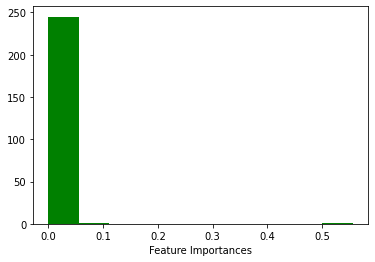

In [32]:
# print out feature importances
dt_reg.fit(train_dev_combined_rebuilt, train_dev_labels)
feature_importances = dt_reg.feature_importances_
plt.hist(feature_importances) # All but one features are at lower end of the spectrum
plt.xlabel("Feature Importances")

important_features = pd.DataFrame({"Feature": df_X_combined_dummies_ordered.columns,\
                                   "Feature_Importance":feature_importances})
important_features.sort_values("Feature_Importance", ascending=False, inplace=True)
cum_sum = pd.DataFrame({"Cumulative_Score": np.cumsum(important_features.Feature_Importance)})
print(pd.concat([important_features, cum_sum], axis=1).head(15))

# <font color=blue>Decision Trees with Bagging
- One can not find feature importances with Bagged Decision Trees


RMSE: 0.13738362705496757
R-squared: 0.943
Slope: 0.791
Slope (in degs): 38.34



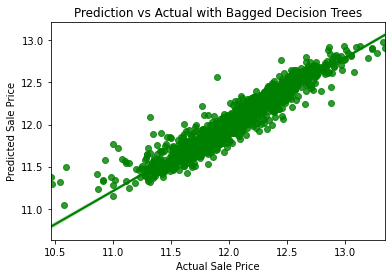

In [33]:
bag_reg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500,\
                           max_samples=600, bootstrap=True, n_jobs=-1,\
                           bootstrap_features=True, max_features=0.5,\
                           oob_score=True)

y_predict = cross_val_predict(bag_reg, train_dev_combined_rebuilt, train_dev_labels)
print("RMSE:", -my_scoring_func(y_predict, train_dev_labels))

slope, intercept, r_value, p_value, std_err = stats.linregress(train_dev_labels, y_predict)
ax = sns.regplot(train_dev_labels, y_predict)
ax.set_title("Prediction vs Actual with Bagged Decision Trees")
ax.set_xlabel("Actual Sale Price")
ax.set_ylabel("Predicted Sale Price")
print("R-squared:", round(r_value, 3))
print("Slope:", round(slope, 3))
print("Slope (in degs):", round(np.arctan(slope)*180/np.pi, 2))
print()

# <font color=blue>Random Forest

RMSE: 0.1381587964269538
R-squared: 0.938
Slope: 0.833
Slope (in degs): 39.81



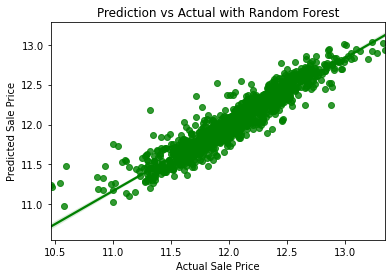

In [34]:
# RF Regression
rf_reg = RandomForestRegressor()
y_predict = cross_val_predict(rf_reg, train_dev_combined_rebuilt, train_dev_labels)
print("RMSE:", -my_scoring_func(y_predict, train_dev_labels))

slope, intercept, r_value, p_value, std_err = stats.linregress(train_dev_labels, y_predict)
ax = sns.regplot(train_dev_labels, y_predict)
ax.set_title("Prediction vs Actual with Random Forest")
ax.set_xlabel("Actual Sale Price")
ax.set_ylabel("Predicted Sale Price")
print("R-squared:", round(r_value, 3))
print("Slope:", round(slope, 3))
print("Slope (in degs):", round(np.arctan(slope)*180/np.pi, 2))
print()

              Feature  Feature_Importance  Cumulative_Score
4         OverallQual            0.558230          0.558230
16          GrLivArea            0.091176          0.649406
37         Total_Area            0.059370          0.708776
12        TotalBsmtSF            0.040461          0.749237
26         GarageCars            0.027179          0.776416
9          BsmtFinSF1            0.019733          0.796149
6           YearBuilt            0.017628          0.813777
27         GarageArea            0.016845          0.830622
191      CentralAir_Y            0.016396          0.847018
13           1stFlrSF            0.016004          0.863022
5         OverallCond            0.011921          0.874943
215  GarageFinish_Unf            0.008319          0.883262
7        YearRemodAdd            0.007190          0.890452
11          BsmtUnfSF            0.004972          0.895423
29        OpenPorchSF            0.004815          0.900238


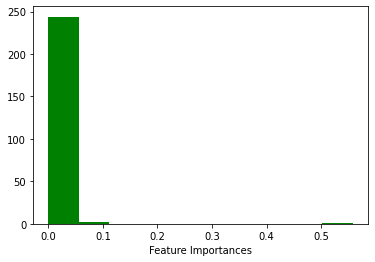

In [35]:
# print out feature importances
rf_reg.fit(train_dev_combined_rebuilt, train_dev_labels)
feature_importances = rf_reg.feature_importances_
plt.hist(feature_importances) # All but one features are at lower end of the spectrum
plt.xlabel("Feature Importances")

important_features = pd.DataFrame({"Feature": df_X_combined_dummies_ordered.columns,\
                                   "Feature_Importance":feature_importances})
important_features.sort_values("Feature_Importance", ascending=False, inplace=True)
cum_sum = pd.DataFrame({"Cumulative_Score": np.cumsum(important_features.Feature_Importance)})
print(pd.concat([important_features, cum_sum], axis=1).head(15))

# <font color=blue>Voting Regressor
As a way to utilize the 'wisdom of the crowd' principle, we started to look into ensemble methods, and found some success. We attempted using VotingRegressor() that incorporated LinearSVM(), ElasticNet() and RandomForestRegressor(). The VotingRegressor() did indeed perform better than each of the components.

Cross-validated RMSE: 0.11011327074485186
R-squared: 0.96
Slope: 0.911
Slope (in degs): 42.34



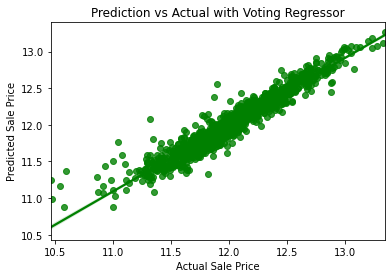

In [36]:
# following is invalid because best_models were trained on train+dev
svm_reg = best_models["svr"]
RF_reg = best_models["xgbr"]
elastic_net = best_models["elasticnet"]

voting_reg = VotingRegressor(estimators=[("svm", svm_reg), 
                                         ("RF", RF_reg), 
                                         ("EN", elastic_net)
                                         ]
                             )
y_predict = cross_val_predict(voting_reg, train_dev_combined_rebuilt, train_dev_labels)
print("Cross-validated RMSE:", -my_scoring_func(y_predict, train_dev_labels))

slope, intercept, r_value, p_value, std_err = stats.linregress(train_dev_labels, y_predict)
ax = sns.regplot(train_dev_labels, y_predict)
ax.set_title("Prediction vs Actual with Voting Regressor")
ax.set_xlabel("Actual Sale Price")
ax.set_ylabel("Predicted Sale Price")
print("R-squared:", round(r_value, 3))
print("Slope:", round(slope, 3))
print("Slope (in degs):", round(np.arctan(slope)*180/np.pi, 2))
print()

# <font color=blue>AdaBoost

Next we implemented AdaBoost on DTs. AdaBoost first trains the base classifier (here, DT) and uses it to make predictions on the training set. Then it increases the weights of examples that were misclassified, and trains a second classifier on this new modified dataset, and so on. Hence called Boosting. Finally, the final model is a weighted-sum of all the decision trees (weighted based on their accuracies).

- With AdaBoost, we obtained cross-validated RMSE of 0.13612
- Feature importances: OverallQual (0.518), GrLivArea(0.095), TotalArea(0.0685) are found to be the top predictors.

Cross-validated RMSE: 0.13688667601785107
R-squared: 0.94
Slope: 0.834
Slope (in degs): 39.81



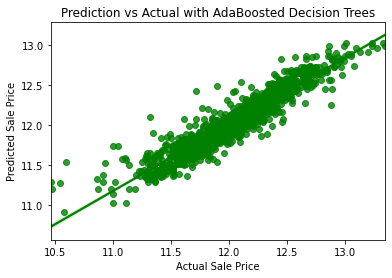

In [37]:
ada_reg = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=30),\
                            n_estimators=500, learning_rate=0.5)
y_predict = cross_val_predict(ada_reg, train_dev_combined_rebuilt, train_dev_labels)
print("Cross-validated RMSE:", -my_scoring_func(y_predict, train_dev_labels))

slope, intercept, r_value, p_value, std_err = stats.linregress(train_dev_labels, y_predict)
ax = sns.regplot(train_dev_labels, y_predict)
ax.set_title("Prediction vs Actual with AdaBoosted Decision Trees")
ax.set_xlabel("Actual Sale Price")
ax.set_ylabel("Predicted Sale Price")
print("R-squared:", round(r_value, 3))
print("Slope:", round(slope, 3))
print("Slope (in degs):", round(np.arctan(slope)*180/np.pi, 2))
print()

          Feature  Feature_Importance  Cumulative_Score
4     OverallQual            0.519334          0.519334
16      GrLivArea            0.098772          0.618106
37     Total_Area            0.067359          0.685466
191  CentralAir_Y            0.030715          0.716181
12    TotalBsmtSF            0.030272          0.746452
13       1stFlrSF            0.022285          0.768737
9      BsmtFinSF1            0.021388          0.790125
27     GarageArea            0.018734          0.808860
6       YearBuilt            0.017558          0.826418
5     OverallCond            0.013880          0.840298
26     GarageCars            0.013178          0.853476
7    YearRemodAdd            0.009753          0.863229
24     Fireplaces            0.007914          0.871143
2     LotFrontage            0.006105          0.877248
0              Id            0.005232          0.882481


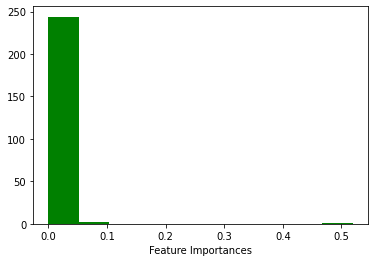

In [38]:
# print out feature importances
ada_reg.fit(train_dev_combined_rebuilt, train_dev_labels)
plt.hist(ada_reg.feature_importances_) # All but one features are at lower end of the spectrum
plt.xlabel("Feature Importances")

important_features = pd.DataFrame({"Feature": df_X_combined_dummies_ordered.columns,\
                                   "Feature_Importance":ada_reg.feature_importances_})
important_features.sort_values("Feature_Importance", ascending=False, inplace=True)
cum_sum = pd.DataFrame({"Cumulative_Score": np.cumsum(important_features.Feature_Importance)})
print(pd.concat([important_features, cum_sum], axis=1).head(15))

# <font color=blue>Gradient Boosted Regression Trees
- RMSE 0.12501
- Can obtain a cool plot of error rate with increasing number of trees
- Feature importances: OverallQual (0.485), GrLivArea(0.129), TotalArea(0.060)

Another approach to boosting is Gradient Boosting. Here, instead of modifying each examples weights, we fit the new regressor to the residual errors of the previous regressor.

Cross-validated RMSE: 0.12028740427120614
R-squared: 0.953
Slope: 0.896
Slope (in degs): 41.86



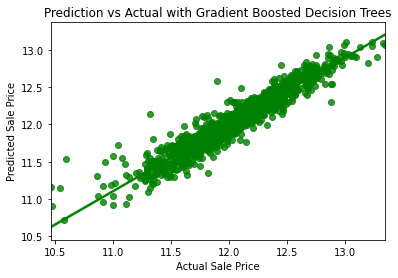

In [39]:
# Gradient Boosted Regression
gb_reg = GradientBoostingRegressor(learning_rate=0.05, n_estimators=300, \
                                   max_depth=4) 
y_predict = cross_val_predict(gb_reg, train_dev_combined_rebuilt, train_dev_labels)
print("Cross-validated RMSE:", -my_scoring_func(y_predict, train_dev_labels))

slope, intercept, r_value, p_value, std_err = stats.linregress(train_dev_labels, y_predict)
ax = sns.regplot(train_dev_labels, y_predict)
ax.set_title("Prediction vs Actual with Gradient Boosted Decision Trees")
ax.set_xlabel("Actual Sale Price")
ax.set_ylabel("Predicted Sale Price")
print("R-squared:", round(r_value, 3))
print("Slope:", round(slope, 3))
print("Slope (in degs):", round(np.arctan(slope)*180/np.pi, 2))
print()

              Feature  Feature_Importance  Cumulative_Score
4         OverallQual            0.493384          0.493384
16          GrLivArea            0.136885          0.630269
37         Total_Area            0.053526          0.683795
12        TotalBsmtSF            0.042405          0.726200
26         GarageCars            0.037683          0.763883
6           YearBuilt            0.028848          0.792732
9          BsmtFinSF1            0.022973          0.815705
215  GarageFinish_Unf            0.021358          0.837063
7        YearRemodAdd            0.020202          0.857265
5         OverallCond            0.016806          0.874071
27         GarageArea            0.014058          0.888128
191      CentralAir_Y            0.013806          0.901934
13           1stFlrSF            0.009732          0.911666
24         Fireplaces            0.009714          0.921380
198    KitchenQual_TA            0.005613          0.926993


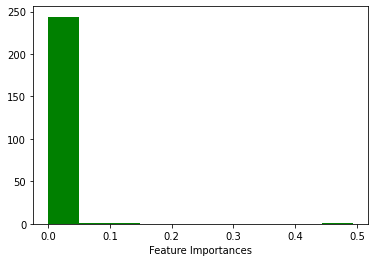

In [40]:
# print out feature importances
gb_reg.fit(train_dev_combined_rebuilt, train_dev_labels)
feature_importances = gb_reg.feature_importances_
plt.hist(feature_importances) # All but one features are at lower end of the spectrum
plt.xlabel("Feature Importances")

important_features = pd.DataFrame({"Feature": df_X_combined_dummies_ordered.columns,\
                                   "Feature_Importance":feature_importances})
important_features.sort_values("Feature_Importance", ascending=False, inplace=True)
cum_sum = pd.DataFrame({"Cumulative_Score": np.cumsum(important_features.Feature_Importance)})
print(pd.concat([important_features, cum_sum], axis=1).head(15))

# <font color=blue>XGBoost with Decision Trees

XGBoost is an optimized implementation of Gradient Boosting, and is often a component of winning entries in Machine Learning competitions, so we gave it a shot. We obtained RMSE of 0.11803.

On the other hand, XGBoost with Random Forests yield worse RMSE, likely trading variance for accuracy.

Cross-validated RMSE: 0.1195907727173066
R-squared: 0.953
Slope: 0.901
Slope (in degs): 42.02



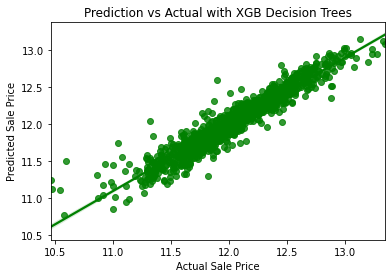

In [41]:
# XGBoosted Regression with Decision Trees
xgbr_reg = xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, \
                                n_estimators=1000, objective="reg:squarederror")
y_predict = cross_val_predict(xgbr_reg, train_dev_combined_rebuilt, train_dev_labels)
print("Cross-validated RMSE:", -my_scoring_func(y_predict, train_dev_labels))

slope, intercept, r_value, p_value, std_err = stats.linregress(train_dev_labels, y_predict)
ax = sns.regplot(train_dev_labels, y_predict)
ax.set_title("Prediction vs Actual with XGB Decision Trees")
ax.set_xlabel("Actual Sale Price")
ax.set_ylabel("Predicted Sale Price")
print("R-squared:", round(r_value, 3))
print("Slope:", round(slope, 3))
print("Slope (in degs):", round(np.arctan(slope)*180/np.pi, 2))
print()

                 Feature  Feature_Importance  Cumulative_Score
26            GarageCars            0.115129          0.115129
215     GarageFinish_Unf            0.074600          0.189730
191         CentralAir_Y            0.061092          0.250822
24            Fireplaces            0.054367          0.305189
4            OverallQual            0.045211          0.350400
41           MSZoning_RL            0.043355          0.393755
16             GrLivArea            0.031094          0.424849
42           MSZoning_RM            0.028938          0.453787
12           TotalBsmtSF            0.027489          0.481276
37            Total_Area            0.026977          0.508253
198       KitchenQual_TA            0.024778          0.533031
7           YearRemodAdd            0.020776          0.553807
184         Heating_Grav            0.020060          0.573867
120  Exterior1st_BrkComm            0.019725          0.593592
239         SaleType_New            0.019526          0

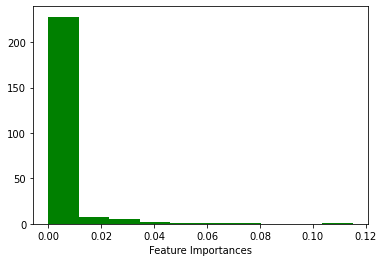

In [42]:
# print out feature importances
xgbr_reg.fit(train_dev_combined_rebuilt, train_dev_labels)
feature_importances = xgbr_reg.feature_importances_
plt.hist(feature_importances) # All but one features are at lower end of the spectrum
plt.xlabel("Feature Importances")

important_features = pd.DataFrame({"Feature": df_X_combined_dummies_ordered.columns,\
                                   "Feature_Importance":feature_importances})
important_features.sort_values("Feature_Importance", ascending=False, inplace=True)
cum_sum = pd.DataFrame({"Cumulative_Score": np.cumsum(important_features.Feature_Importance)})
print(pd.concat([important_features, cum_sum], axis=1).head(15))

# <font color=blue>Bayesian Ridge
Surprisingly, Bayesian Ridge yielded a decent RMSE of 0.11268 and hence became a major component of our subsequent model stack.

Cross-validated RMSE: 0.11431985358856578
R-squared: 0.957
Slope: 0.921
Slope (in degs): 42.64



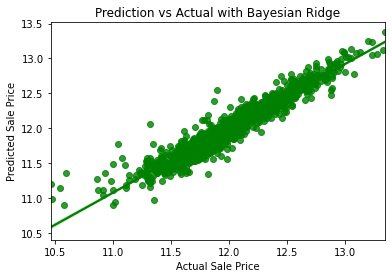

In [43]:
# Bayesian Ridge Regression
br_reg = BayesianRidge() #best_models["br"]
y_predict = cross_val_predict(br_reg, train_dev_combined_rebuilt, train_dev_labels)
print("Cross-validated RMSE:", -my_scoring_func(y_predict, train_dev_labels))

slope, intercept, r_value, p_value, std_err = stats.linregress(train_dev_labels, y_predict)
ax = sns.regplot(train_dev_labels, y_predict)
ax.set_title("Prediction vs Actual with Bayesian Ridge")
ax.set_xlabel("Actual Sale Price")
ax.set_ylabel("Predicted Sale Price")
print("R-squared:", round(r_value, 3))
print("Slope:", round(slope, 3))
print("Slope (in degs):", round(np.arctan(slope)*180/np.pi, 2))
print()

# <font color=blue> Light GBM

Cross-validated RMSE: 0.11885145403389936
R-squared: 0.954
Slope: 0.908
Slope (in degs): 42.25



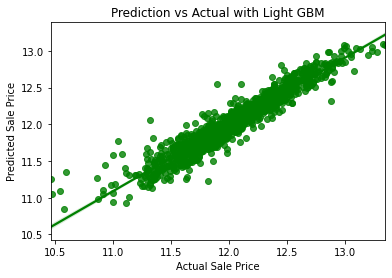

In [44]:
# Light GBM Regression
lightgbm_reg = best_models["lightgbm"]
y_predict = cross_val_predict(lightgbm_reg, train_dev_combined_rebuilt, train_dev_labels)
print("Cross-validated RMSE:", -my_scoring_func(y_predict, train_dev_labels))

slope, intercept, r_value, p_value, std_err = stats.linregress(train_dev_labels, y_predict)
ax = sns.regplot(train_dev_labels, y_predict)
ax.set_title("Prediction vs Actual with Light GBM")
ax.set_xlabel("Actual Sale Price")
ax.set_ylabel("Predicted Sale Price")
print("R-squared:", round(r_value, 3))
print("Slope:", round(slope, 3))
print("Slope (in degs):", round(np.arctan(slope)*180/np.pi, 2))
print()

# <font color=blue>Stacking and Blending with StackingCVRegressor()
Instead of simple averaging the predictions of base estimators as in VotingRegressor(), we can train a meta model that takes as input the predictions of the base model and performs regression on it. This meta model is called a blender. We used StackingCVRegressor() to train this meta model. In particular, there is an option to train the meta-model on the origin input (with all features) along with the base estimator predictions, but we found it gave worse prediction RMSE. Hence, we set "use_features_in_secondary" to False. 



## <font color=blue> Optimize hyperparameters on train+dev set

In [0]:
alphas_elasticnet = list(np.linspace(0.0007,0.0018,10)) 
l1_ratio_elasticnet = list(np.linspace(0.3,0.9,10)) 
alphas_lasso = list(np.linspace(0.0002,0.0012,10)) 
alphas_ridge = list(np.linspace(10,26,10)) 
C_svm = list(np.linspace(0.007,0.017,10)) 
epsilon_svm = list(np.linspace(0.006,0.06,10))
gamma_svm = [1e-4, 2.5e-4, 0.5e-3, 0.75e-3, 1e-3, 1.25e-3] 

parameters = {"elasticnet":{"alpha": alphas_elasticnet, 
                            "l1_ratio": l1_ratio_elasticnet  
                            },
              "lasso":{"alpha": alphas_lasso 
                       },
              "ridge":{"alpha": alphas_ridge,
                       },
              "svr":{"kernel": ["rbf", "linear"], 
                     "C": C_svm, 
                     "epsilon": epsilon_svm, 
                     "gamma": gamma_svm 
                     },
              "gbr":{"max_depth" : [2,3,4],
                     "learning_rate" : [0.1,0.075, 0.05,0.025, 0.01], 
                     "n_estimators" : [350, 500, 650, 750, 850, 1000], 
                     "subsample": list(np.linspace(0.6, 1, 10)) 
                     },
              "xgbr":{"max_depth" : [2,3, 4, 5, 6, 7, 10], 
                      "learning_rate" : [0.05,0.025,0.01,0.0075, 0.005], 
                      "subsample" : list(np.linspace(0.5, 1, 10)), 
                      "n_estimators" : [750, 1000, 1250, 1500, 2000] 
                      },
              "lightgbm":{"n_estimators" : [200,300,400,500,700, 800],
                          'num_leaves': [2,4,5,6,10], 
                          'max_depth': [5,10, 15, 30],
                          'learning_rate': [0.15, 0.25, 0.35, 0.45], 
                          'reg_alpha': list(np.linspace(0.1, 0.3, 10)),
                          'reg_lambda': list(np.linspace(0.1, 0.4, 10)) 
                          },
              "br":{'alpha_1': [1e-6, 1e-3, 0.1]
                    }
              }

models = {"elasticnet": ElasticNet(),
        "lasso": Lasso(),
        "ridge": Ridge(),
        "svr": SVR(),        
        'gbr': GradientBoostingRegressor(),
        'xgbr': XGBRegressor(objective ='reg:squarederror'),
        'lightgbm': LGBMRegressor(),
        'br':BayesianRidge()
        }

In [0]:
# # DO NOT RUN: Takes ~22 min to finish
# # uncomment to run

# start = time.time()
# best_models = {} 
# model_scores = []
# for model in models.keys():
#     print('working on:', model)
#     #break
#     rs_cv_model=RandomizedSearchCV(models[model], 
#                                    parameters[model],
#                                    scoring="neg_root_mean_squared_error",
#                                    verbose=1,
#                                    n_iter=10)
#     #rs_cv_model.fit
#     rs_cv_model.fit(train_dev_combined_rebuilt, y = train_dev_labels)
#     best_models[model] = rs_cv_model.best_estimator_
#     print (model,'score: ', -rs_cv_model.best_score_)
#     model_scores.append([model, -rs_cv_model.best_score_])


# stack_gen_model = StackingCVRegressor(regressors=(best_models["ridge"],best_models["lasso"],best_models["elasticnet"],best_models["gbr"],\
#                                             best_models["xgbr"],best_models["lightgbm"],best_models["svr"],best_models["br"]),\
#                                 meta_regressor=best_models["xgbr"],use_features_in_secondary=False)
# best_models["stack_gen_model"] = stack_gen_model

# end = time.time()
# print("Total time taken (in min):", round((end-start)/60,1)) # ~22 min

In [47]:
# # Uncomment to save the hyperparameter search

# best_models_file = best_models
# best_models_save_path = F"/content/gdrive/My Drive/207_Ames House Price Prediction Project/house-prices-advanced-regression-techniques/models/best_models_file.pkl"

# # #https://colab.research.google.com/drive/1CN7JxLA_Qk1Clc4CM75rSAqIlUKIF8xZ
# # import joblib
# drive.mount('/content/gdrive')
# joblib.dump(best_models_file, best_models_save_path)

# # # show content
# # !ls gdrive/"My Drive"/'207_Ames House Price Prediction Project'/"house-prices-advanced-regression-techniques/models"

# to load the saved file, specify the full path for the file
# best_models_file.pkl is the RandomizedSearchCV saved models (trained on train+dev)

# please customize the path to be able to run this
drive.mount('/content/gdrive')
best_models_save_path = F"/content/gdrive/My Drive/207_Ames House Price Prediction Project/house-prices-advanced-regression-techniques/models/best_models_file.pkl"
best_models = joblib.load(best_models_save_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [48]:
import time
start_time = time.time()
print("Start fitting")
X = train_dev_combined_rebuilt
y = train_dev_labels
print("Ridge")
ridge_model = best_models["ridge"].fit(X,y)
print("Lasso")
lasso_model = best_models["lasso"].fit(X,y)
print("Elasticnet")
elastic_model = best_models["elasticnet"].fit(X,y)
print("SVR")
svr_model = best_models["svr"].fit(X,y)
print("GradientBoostRegression")
gbr_model = best_models["gbr"].fit(X,y)
print("LightGBM")
lightgbm_model = best_models["lightgbm"].fit(X,y)
print("XGBoostRegression")
xgbr_model = best_models["xgbr"].fit(X,y)
print("BR")
br_model = best_models["br"].fit(X,y)
print("Stack")
stack_gen_model = best_models["stack_gen_model"].fit(np.array(X),np.array(y))
end_time = time.time()
print("Time (in min) to execute this stack:", round((end_time - start_time)/60, 1)) 

Start fitting
Ridge
Lasso
Elasticnet
SVR
GradientBoostRegression
LightGBM
XGBoostRegression
BR
Stack
Time (in min) to execute this stack: 1.5


# <font color=blue>Kaggle prediction of linear combination of base estimators and the blender

# <font color=blue> This gave our best Kaggle RMSE score of 0.11654 which put us at 465 position on the Kaggle leaderboard.

In [0]:
# Kaggle prediction of linear combination of base estimators and the blender

model_weights = [0.02, 0.02, 0.01, 0.65, 0.1, 0.2, 0.1, 0.55, 0.65]


def blend_models_predict_opt(X=test_combined_rebuilt, 
                             models=best_models,
                             model_weights=model_weights):
  """
  returns predictions as a linear combination of predictions from 
  component models and the blender model. The blender model is made up of the 
  component models.

  """

  elastic_, lasso_, ridge_, svr_, gbr_, xgbr_, lightgbm_, br_, stack_ = model_weights
  sum_ = np.sum(np.array(model_weights))

  return ((elastic_ * best_models["elasticnet"].predict(X)) + \
          (lasso_ * best_models["lasso"].predict(X)) + \
          (ridge_ * best_models["ridge"].predict(X)) + \
          (svr_ * best_models["svr"].predict(X)) + \
          (gbr_ * best_models["gbr"].predict(X)) + \
          (xgbr_ * best_models["xgbr"].predict(X)) + \
          (lightgbm_ * best_models["lightgbm"].predict(X)) + \
          (br_ * best_models["br"].predict(X)) + \
          (stack_ * best_models["stack_gen_model"].predict(X))) * sum_**-1

y_predict = blend_models_predict_opt(X=test_combined_rebuilt, models=best_models, model_weights=model_weights )

In [50]:
# this gave a Kaggle score of 0.11654

drive.mount('/content/gdrive')
test_predict = np.exp(y_predict)
df_test_results = pd.DataFrame(test_predict, np.arange(1461,2920), columns=["SalePrice"])
df_test_results.index.name = "Id"
df_test_results.to_csv("Stacking_v17.csv") 
!cp Stacking_v17.csv "/content/gdrive/My Drive/207_Ames House Price Prediction Project/house-prices-advanced-regression-techniques/models/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# <font color=blue> Summary of RMSE of all models discussed above

In [51]:
# Summary of RMSE of all models discussed above
model_name = ['Lasso',
 'Ridge',
 'Elasticnet',
 'SVR',
 'GBRT',
 'XGBoost',
 'Bayesian_Ridge',
 'Light_GBM',
 "Stack + XGBoost meta-estimator",
 "Linear_combination_all_above"]

CV = [0.11214,
 0.11263,
 0.11252999999999999,
 0.11225,
 0.12078,
 0.11803,
 0.11268,
 0.11709,
 "","" ]

Kaggle_score = [0.12169,
 0.12084,
 0.12049000000000001,
 0.12311,
 0.13388,
 0.1315,
 0.12084,
 0.1256,
 0.12290,
 0.11654]

model_scores = pd.DataFrame([CV, Kaggle_score]).T
model_scores.columns=["Cross-validated RMSE", "Kaggle RMSE"]
model_scores.index = pd.Series(model_name)
print(model_scores)

                               Cross-validated RMSE Kaggle RMSE
Lasso                                       0.11214     0.12169
Ridge                                       0.11263     0.12084
Elasticnet                                  0.11253     0.12049
SVR                                         0.11225     0.12311
GBRT                                        0.12078     0.13388
XGBoost                                     0.11803      0.1315
Bayesian_Ridge                              0.11268     0.12084
Light_GBM                                   0.11709      0.1256
Stack + XGBoost meta-estimator                           0.1229
Linear_combination_all_above                            0.11654


In [52]:
print("Ran successfully!")

Ran successfully!
